## ANOVA for Feature Selection (Classification)

ANOVA (Analysis of Variance) is a univariate statistical test used to determine whether the mean values of a feature differ significantly across multiple classes.

In feature selection, ANOVA answers the question:

_Does this feature have significantly different distributions across target classes?_

If the answer is yes, the feature is considered informative and receives a high score.

---

### Step 1: Compute the Overall Mean

$$
\bar{X} = \frac{1}{N} \sum_{i=1}^{N} X_i
$$

- $N$ = total number of samples
- $X_i$ = value of feature $X$ for sample $i$

---

### Step 2: Compute the Class Means

$$
\bar{X}_c = \frac{1}{N_c} \sum_{i \in C_c} X_i
$$

- $c$ = class label
- $N_c$ = number of samples in class c
- $\bar{X}\_c$ = mean of feature X in class c

---

### Step 3: Compute Between-Class Variance (SSB)

$$
SSB = \sum_{c=1}^{k} N_c (\bar{X}_c - \bar{X})^2
$$

- $k$ = number of classes
- Measures how far each class mean is from the overall mean

---

### Step 4: Compute Within-Class Variance (SSW)

$$
SSW = \sum_{c=1}^{k} \sum_{i \in C_c} (X_i - \bar{X}_c)^2
$$

- Measures variance **within each class**
- Captures noise or spread inside each class

---

### Step 5: Compute the F-Statistic

$$
F = \frac{SSB / (k - 1)}{SSW / (N - k)}
$$

- $k$ = number of classes
- $k-1$ = degrees of freedom for between-class
- $N-k$ = degrees of freedom for within-class
- Large $F$ → feature separates classes well
- Small $F$ → feature is not informative

---

### Step 6: Rank Features

- Compute $F$ for all features independently
- Rank features by $F$ score
- Keep **top k features** or **top percentile**

### Step 7: Implementation in scikit-learn

```python
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(score_func=f_classif, k=5)
X_selected = selector.fit_transform(X, y)
```

---


## ANOVA / F-Test for Regression

In regression, the goal is to select features that are **strongly linearly associated** with the continuous target $y$.

### Step 1: Fit Simple Linear Regression per Feature

For each feature $X_j$, fit a univariate linear model:

$$
y_i = \beta_0 + \beta_1 X_{ij} + \epsilon_i
$$

- $y_i$ = target for sample $i$
- $X_{ij}$ = value of feature $j$ for sample $i$
- $\epsilon_i$ = residual error

---

### Step 2: Compute Explained and Residual Variance

- **Regression sum of squares (explained variance):**

$$
SSR_j = \sum_{i=1}^{N} (\hat{y}_i - \bar{y})^2
$$

- **Residual sum of squares (unexplained variance):**

$$
SSE_j = \sum_{i=1}^{N} (y_i - \hat{y}_i)^2
$$

Where $\hat{y}_i$ = predicted value from univariate regression, and $\bar{y}$ = mean of target.

---

### Step 3: Compute the F-Statistic

$$
F_j = \frac{SSR_j / 1}{SSE_j / (N - 2)}
$$

- Numerator df = 1 (since one predictor in univariate test)
- Denominator df = $N-2$
- Large $F_j$ → feature explains significant variance in $y$
- Small $F_j$ → weak predictive power

---

### Step 4: Rank and Select Features

- Compute $F_j$ for all features
- Rank features by $F$-score
- Select **top k features** or **top percentile**

---

### Step 5: Implementation in scikit-learn

```python
from sklearn.feature_selection import SelectKBest, f_regression

selector = SelectKBest(score_func=f_regression, k=5)
X_selected = selector.fit_transform(X, y)
```

---

- _F-scores for all features_

`python selector.scores_`

- _p-values for all features_

`selector.pvalues_`

- _Mask of selected features_

`selector.get_support()`


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits, load_diabetes
from sklearn.feature_selection import SelectKBest, f_classif, f_regression, VarianceThreshold

### ANOVA For a Classification Problem


In [2]:
df = load_digits()
X = pd.DataFrame(data=df.data, columns=df.feature_names)
y = pd.DataFrame(data=df.target)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [4]:
univariate = f_classif(X_train, y_train)
anova_results = pd.DataFrame(
    {'Feature': X_train.columns,
     'F-Score': univariate[0],
     'p-Value': univariate[1]})
anova_results = anova_results.sort_values(by='F-Score', ascending=False)
anova_results

/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 0 32 39] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


,Feature,F-Score,p-Value
33,pixel_4_1,246.507847,3.421960e-283
26,pixel_3_2,227.615814,1.931402e-268
42,pixel_5_2,213.253614,9.743269e-257
34,pixel_4_2,202.401777,1.358482e-247
28,pixel_3_4,192.360057,6.939389e-239
...,...,...,...
24,pixel_3_0,0.887526,5.356605e-01
16,pixel_2_0,0.665308,7.409301e-01
0,pixel_0_0,NaN,NaN
32,pixel_4_0,NaN,NaN


We have constant features and must be removed.


In [5]:
variance_sel = VarianceThreshold(threshold=0)
X_train_clean = variance_sel.fit_transform(X_train)
X_test_clean = variance_sel.transform(X_test)

In [6]:
X_train_clean = pd.DataFrame(X_train_clean, columns=variance_sel.get_feature_names_out())
X_test_clean = pd.DataFrame(X_test_clean, columns=variance_sel.get_feature_names_out())

In [7]:
univariate = f_classif(X_train_clean, y_train)
anova_results = pd.DataFrame(
    {'Feature': variance_sel.get_feature_names_out(),
     'F-Score': univariate[0],
     'p-Value': univariate[1]})
anova_results = anova_results.sort_values(by='F-Score', ascending=False)
anova_results

/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Feature,F-Score,p-Value
31,pixel_4_1,246.507847,3.421960e-283
25,pixel_3_2,227.615814,1.931402e-268
39,pixel_5_2,213.253614,9.743269e-257
32,pixel_4_2,202.401777,1.358482e-247
27,pixel_3_4,192.360057,6.939389e-239
...,...,...,...
45,pixel_6_0,1.465174,1.555792e-01
7,pixel_1_0,1.068036,3.835212e-01
53,pixel_7_0,0.997671,4.397858e-01
23,pixel_3_0,0.887526,5.356605e-01


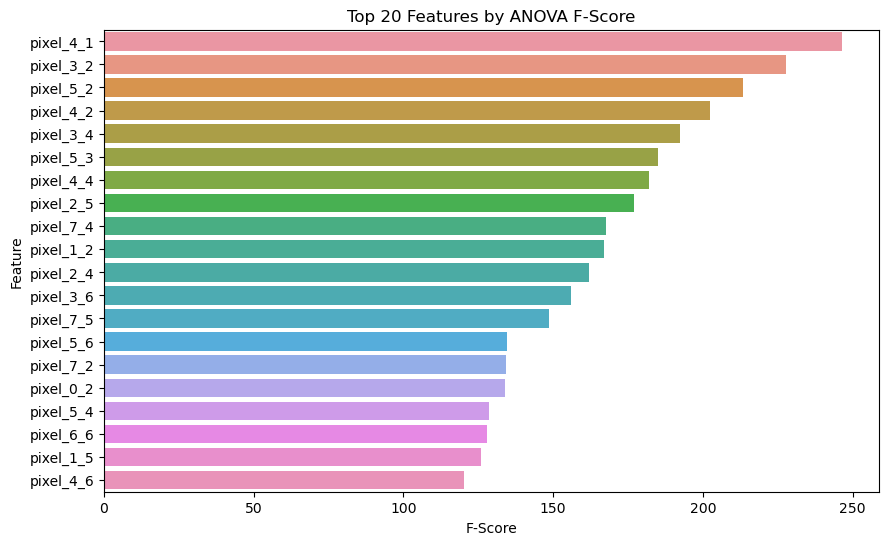

In [8]:
plt.figure(figsize=(10, 6))
sns.barplot(x='F-Score', y='Feature', data=anova_results.head(20))
plt.title('Top 20 Features by ANOVA F-Score')
plt.xlabel('F-Score')
plt.ylabel('Feature')
plt.show()

In the plot, you can see that even the 20th-ranked feature has an F-score greater than 120 and very low p-values. This indicates that the feature still has significant discriminative power relative to the target. However, this does not necessarily imply that the feature is highly useful, because p-values are influenced by the dataset: with a larger sample size, p-values tend to be lower, and F-scores can be lighter even for less important features.

It is also important to note that ANOVA assumes **linearity** between the feature and the target. Features that have non-linear relationships with the target may not be properly evaluated using ANOVA F-tests.

In practice, we may still select fewer features because:

- **Dimensionality reduction** – Fewer features reduce computational cost and simplify the model.
- **Noise control** – Lower-ranked features may contain more noise, which can hurt generalization.
- **Most of the signal is in the top features** – The top 10 features usually capture the majority of the variance between classes.


In [9]:
# Automatically select the top 10 features
selector = SelectKBest(score_func=f_classif, k=10)
X_train_selected = selector.fit_transform(X_train_clean, y_train)
X_test_selected = selector.transform(X_test_clean)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [10]:
selector.get_feature_names_out()

array(['pixel_1_2', 'pixel_2_5', 'pixel_3_2', 'pixel_3_4', 'pixel_4_1',
       'pixel_4_2', 'pixel_4_4', 'pixel_5_2', 'pixel_5_3', 'pixel_7_4'],
      dtype=object)

### ANOVA For a Regression Problem


In [11]:
df = load_diabetes()

X = pd.DataFrame(data=df.data, columns=df.feature_names)
y = pd.DataFrame(data=df.target)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [13]:
# ANOVA F-value for the features
anova_selector = SelectKBest(score_func=f_regression, k=10)
X_train_selected = anova_selector.fit_transform(X_train, y_train)
X_test_selected = anova_selector.transform(X_test)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [14]:
anova_selector.get_feature_names_out()

array(['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6'],
      dtype=object)

All of the methods explored so far, such as ANOVA F-tests and SelectKBest based on F-scores, are widely used in **genomic and biological research**. In these fields, the goal is often to **rank features** (e.g., genes) according to their statistical association with a phenotype, and the datasets typically have **very high dimensionality and relatively small sample sizes**, which makes univariate filtering methods practical and interpretable.

However, these methods are **less commonly used in general machine learning problems** because they:

- Consider **each feature independently**, ignoring interactions or correlations between features.
- Assume **linear relationships** (in the case of ANOVA F-tests), which may not hold for complex datasets.
- May not align with **model-specific objectives**, where predictive performance depends on multivariate relationships.

As a result, while useful for exploratory analysis and feature ranking in biology, they are often supplemented or replaced by **embedded or wrapper methods** in broader machine learning applications.

_We can use ANOVA (or F-test, Fisher score) as a first filtering step when dealing with high-dimensional datasets (e.g., 500+ features) for machine learning. The purpose here is dimension reduction, not final feature selection._


---

### Notes on F-scores, p-values, and multiple testing corrections

While F-scores provide a way to rank features according to their ability to separate classes, **we usually do not rely solely on F-scores** for feature selection. There are several reasons for this:

- F-scores are **univariate** and ignore interactions between features.
- They are **sensitive to outliers and class imbalance**, which can inflate the scores and lead to misleading selections.

Similarly, **p-values**, although they indicate statistical significance, **cannot be trusted alone** in high-dimensional datasets, because performing many tests simultaneously increases the likelihood of false positives.

To account for this, we apply **multiple testing corrections**:

- **FDR (False Discovery Rate)** – controls the expected proportion of false positives among selected features.
- **FWE (Family-Wise Error)** – controls the probability of making at least one false positive.
- **FPR (False Positive Rate)** – represents the likelihood of falsely rejecting a null hypothesis in a single test.

**Reliable feature selection** requires comparing each feature's p-value against these corrected thresholds:

- If the p-value is **lower than the threshold**, the feature can be considered statistically significant and selected.
- If the p-value is **small but larger than the threshold**, it may represent a false positive and should be rejected.

Using these corrections ensures that the selected features are **robust and less likely to be falsely identified as important**, providing a more reliable foundation for downstream analyses or machine learning tasks.


#### Univariate Feature Selection with `GenericUnivariateSelect`

Scikit-learn provides the module `sklearn.feature_selection.generic_univariate_select` to perform **univariate feature selection** in a flexible way. This module allows you to:

- Work with **classification** or **regression** tasks.
- Choose from different **scoring functions** (e.g., `f_classif`, `mutual_info_classif` for classification; `f_regression`, `mutual_info_regression` for regression).
- Apply different **selection strategies**, such as keeping the top `k` features or a fixed percentile.
- Allows selecting mode `fdr`, `fdr`, and `fwe`

By **default**, `GenericUnivariateSelect` uses `f_classif` for classification tasks, which computes the **ANOVA F-value** between each feature and the target.

---

```python

from sklearn.feature_selection import GenericUnivariateSelect, f_regression

# Example with FDR control
selector = GenericUnivariateSelect(score_func=f_classif, mode='fdr', param=0.05)
X_selected = selector.fit_transform(X, y)
```

Here, param=0.05 is the maximum allowed FDR.

---

`GenericUnivariateSelect` selects features based purely on scores (F-score, chi2, mutual_info) and the chosen selection strategy (`k_best`, `percentile`, `fpr`, `fdr`, `fwe`).

```python
# Select top 10 features
selector = GenericUnivariateSelect(score_func=f_classif, mode='k_best', param=10)
```

Here, param=10 is the top 10 features by F-score.

---

If you want to select features based on p-values with FDR/FWE/FPR control, you need to set:

```python
mode='fdr'   # or 'fwe', 'fpr'
param=0.05   # threshold
```
